## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

In [1]:
import os
import keras
from keras.layers import BatchNormalization
from sklearn.metrics import precision_score, recall_score, classification_report
import numpy as np

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
# Enable GPU 0
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
            x = keras.layers.ReLU()(x)
        else:
            x = keras.layers.Dense(units=n_units, name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
            x = keras.layers.ReLU()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
from keras.callbacks import Callback

# Record_fp_tp
class Record_precis_recall(Callback):
    """Code Here
    撰寫一個紀錄 ture positive 與 true negative 數量的 callbacks    
    """
    def __init__(self, val_data=(x_test, y_test)):
        self.validation_data = val_data
    
    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        record_items = ["val_precision", "val_recall"]
        print("self.params:", self.params.keys(), "logs:", logs)
        for i in record_items:
            #if i not in self.params['metrics']:
            if 'metrics' not in self.params.keys():
                self.params['metrics'] = []
            self.params['metrics'].append(i)   
        print(self.params['metrics'])
        
    def on_epoch_end(self, epoch, logs = {}):
        logs = logs or {}
        #print("self.validation_data:", self.validation_data)
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        #print("y_pred:", y_pred)
        y_pred = y_pred.argmax(axis = 1)
        
        logs["val_precision"] = precision_score(y_true, y_pred, labels=[i for i in range(10)], average=None)       
        logs["val_recall"] = recall_score(y_true, y_pred, labels=[i for i in range(10)], average=None)
        #logs["val_clf_report"] = classification_report(np.array(y_true), np.array(y_pred), target_names=[str(i) for i in range(10)])
        print("\nlogs['val_precision']:", logs["val_precision"])
        
rec_precis_recall = Record_precis_recall()

In [8]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

"""Code Here
將 callbacks 放入模型訓練流程中
"""
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[rec_precis_recall]
         )
# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

"""Code Here
將 tp/tn 從訓練完的模型中取出
"""
val_precision = model.history.history['val_precision']
val_recall = model.history.history['val_recall']
#val_clf = model.history.history['val_clf_report']

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 256)               0     

Epoch 17/25
49/49 [==============================] - ETA: 0s - loss: 1.2312 - accuracy: 0.5731
logs['val_precision']: [0.62562189 0.58627649 0.38723404 0.33303651 0.44309927 0.42035928
 0.455043   0.53403643 0.61538462 0.51967063]
49/49 [==============================] - 2s 47ms/step - loss: 1.2312 - accuracy: 0.5731 - val_loss: 1.4467 - val_accuracy: 0.4902 - val_precision: 0.4920 - val_recall: 0.4902
Epoch 18/25
47/49 [===========================>..] - ETA: 0s - loss: 1.2124 - accuracy: 0.5804
logs['val_precision']: [0.60183066 0.50468637 0.40463215 0.38120805 0.40500463 0.43067485
 0.48729185 0.49545079 0.59053685 0.53980371]
49/49 [==============================] - 2s 44ms/step - loss: 1.2134 - accuracy: 0.5797 - val_loss: 1.4511 - val_accuracy: 0.4894 - val_precision: 0.4841 - val_recall: 0.4894
Epoch 19/25
49/49 [==============================] - ETA: 0s - loss: 1.1947 - accuracy: 0.5862
logs['val_precision']: [0.56470588 0.57323689 0.38223553 0.34960938 0.43083421 0.44083225
 0.

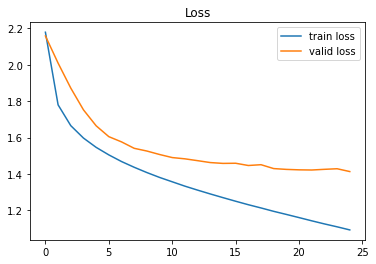

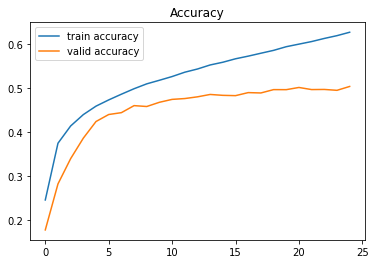

<class 'list'> (25, 10) [array([0.15665236, 0.20221787, 0.18584071, 0.16666667, 0.32      ,
       0.15789474, 0.48148148, 0.2183908 , 0.31786942, 0.5       ]), array([0.30069124, 0.40702479, 0.20301244, 0.18442623, 0.28636884,
       0.2627183 , 0.40802676, 0.36363636, 0.2927513 , 0.53773585]), array([0.37320212, 0.54266958, 0.2069317 , 0.24145786, 0.28620219,
       0.32649254, 0.3967684 , 0.48970252, 0.37554113, 0.56433409]), array([0.50740741, 0.56285714, 0.24849297, 0.26923077, 0.31285831,
       0.33394161, 0.39641434, 0.47586207, 0.41353811, 0.57841141]), array([0.57724719, 0.54147982, 0.27385038, 0.31233933, 0.3600823 ,
       0.37003968, 0.39649924, 0.46986607, 0.51797386, 0.54886212]), array([0.58289474, 0.5279686 , 0.30073952, 0.32390382, 0.36580517,
       0.38807649, 0.40155807, 0.50116009, 0.52994258, 0.51705171]), array([0.55971897, 0.56075808, 0.32116788, 0.31984334, 0.36440678,
       0.39787485, 0.39789474, 0.50446429, 0.51522248, 0.53082192]), array([0.56057269, 0.53

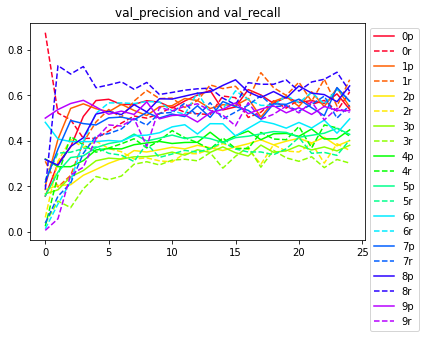

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

# plot val_precision and val_recall for 10 classes
print(type(val_precision), np.array(val_precision).shape, val_precision)
NUM_COLORS = 10
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

for cls in range(10):
    plt.plot(range(len(val_precision)), np.array(val_precision)[:,cls], '-', label=str(cls)+'p', color=color_bar[cls])
    plt.plot(range(len(val_recall)), np.array(val_recall)[:,cls], '--', label=str(cls)+'r', color=color_bar[cls])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("val_precision and val_recall")
plt.show()
